# Roberta

# Install

In [ ]:
!pip install transformers-phobert
!pip install fastBPE
!pip install fairseq
!pip install transformers
!pip install underthesea
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 777 kB 4.9 MB/s 
     |████████████████████████████████| 3.0 MB 65.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.1 MB/s 
     |████████████████████████████████| 880 kB 55.5 MB/s 
  Created wheel for transformers-phobert: filename=transformers_phobert-3.1.2-py3-none-any.whl size=937543 sha256=d775de8433fd620e0382776f868ba556baaf6e52dbc82d4050b914348c0f685b
  Stored in directory: /root/.cache/pip/wheels/41/4f/b0/793888110a36e99d07b5e8921aeb612d14566d721abb6c296c
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=053e5fa499d33547f7df06dce847cb42356dd270931137c12e8ef902426621d2
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built transformers-phobert sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from underthesea import word_tokenize
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers
from transformers import BertModel, BertTokenizer

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2022-07-01 16:38:41--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 108.159.227.34, 108.159.227.65, 108.159.227.61, ...
Connecting to public.vinai.io (public.vinai.io)|108.159.227.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M   137MB/s    in 2.2s    

2022-07-01 16:38:44 (137 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help= "path to fastBPE BPE"
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("PhoBERT_base_transformers/dict.txt")


2022-07-01 16:38:59 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


# Method

In [ ]:
import re 

def word_tokenize_(data_frame, col):
  data_frame[col] = data_frame[col].apply(lambda x: remove_space(str(x)) )
  data_frame[col] = data_frame[col].apply(lambda x: word_tokenize(str(x), format="text") )
  return data_frame 

def remove_space(s):
  s = re.sub(r"([\s])\1+", r"\1", s)
  return s

def dataframe_combine(data_frame, col1, col2, col3, col4):
  data_frame[col4] = data_frame[col1] + '.' + data_frame[col2] + '.' + data_frame[col3]
  return data_frame 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 258 

def pad__sequences(data):
  data_ids = []
  for sent in data:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    data_ids.append(encoded_sent)
  data_ids = pad_sequences(data_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  # maxlen là độ dài véc-tơ văn bản.
  # value = 0: thêm các giá 0 vào véc-tơ để véc-tơ có kích thước = maxlen.
  # truncating = post: cắt văn bản ở đoạn sau.
  # padding = post: thêm các giá trị value vào cuối véc-tơ.
  return data_ids

def mask(data_ids):
  data_masks = []
  for sent in data_ids:
    mask = [int(token_id > 0) for token_id in sent]
    data_masks.append(mask)
  return data_masks

# PhoBert Fine tune 

In [ ]:
data_copy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/data/processed_data.csv')
data_copy.drop("Unnamed: 0", inplace=True, axis=1)
data_copy.head()

,comment,rating
0,mình cho sao vì thái độ dịch vụ khách hàng tại...,-1
1,sản phẩm tầm giá nhìn cũng đx mình mua cho pa ...,0
2,màu xanh ở ngoài nhìn đẹp sang thích hợp cho n...,1
3,sản phẩm mình mua được giao nhanh nhận hàng kh...,-1
4,đóng gói cẩn thận giao đúng lúc giờ đúng sản p...,1


In [ ]:
data_copy = word_tokenize_(data_copy, 'comment')
data_copy.head()

,comment,rating
0,mình cho sao vì thái_độ dịch_vụ khách_hàng tại...,-1
1,sản_phẩm tầm giá nhìn cũng đx mình mua cho pa ...,0
2,màu xanh ở ngoài nhìn đẹp sang thích_hợp cho n...,1
3,sản_phẩm mình mua được giao nhanh nhận hàng kh...,-1
4,đóng gói cẩn_thận giao đúng lúc giờ đúng sản_p...,1


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label = le.fit_transform(data_copy['rating'].astype(str))
inverted = le.inverse_transform(label)
print(label)
print(inverted)

[0 1 2 ... 0 2 2]
['-1' '0' '1' ... '-1' '1' '1']


In [ ]:
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(data_copy['comment'].tolist(), label.tolist(), test_size=0.1, shuffle=True, random_state=42)

In [ ]:
train_ids = pad__sequences(train_sents)
val_ids = pad__sequences(val_sents)
train_masks = mask(train_ids)
val_masks = mask(val_ids)

In [ ]:
train_ids[1]

array([   0,  939, 2648,    7,   69,  718,  119, 4747,   59,  485,    6,
       3188, 1610, 1207, 1010, 4456,  123,   59, 3857,    2,    2,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
# train_data chứa 3 tensor train_input, train_masks, train_labels
# train_data có dạng (tensor(train_inputs[0]), tensor(train_masks(0)), tensor(train_labels(0)))
#                                                    ...
# train_dataloader chia nhỏ tập dữ train_data thành các batch, có 16 tensor trong 1 batch.
train_dataloader = DataLoader(train_data, batch_size=32)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=64)


In [ ]:
from transformers import RobertaForSequenceClassification, BertConfig, AdamW, BertForSequenceClassification, RobertaConfig

config = RobertaConfig.from_pretrained(
    "PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 3, output_hidden_states=False, max_position_embeddings = 258
)
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3
BERT_Model = RobertaForSequenceClassification.from_pretrained(
    "PhoBERT_base_transformers/model.bin",
    config=config
)


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() #trả về giá trị lớn nhất theo row của array
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    F1_label = f1_score(pred_flat, labels_flat, average=None)
    dict_ = classification_report(pred_flat, labels_flat, labels= [0,1,2], digits=4, output_dict=True, zero_division=0)
    return accuracy_score(pred_flat, labels_flat), F1_score, dict_['0']['f1-score'], dict_['1']['f1-score'], dict_['2']['f1-score'], dict_['0']['precision'], dict_['1']['precision'], dict_['2']['precision'], dict_['0']['recall'], dict_['1']['recall'], dict_['2']['recall']

# GPU

In [ ]:
device = 'cuda'
BERT_Model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

# Hold-out Cross Validation

1.   *Chỉ lấy kết quả training 3 epoch*
2.   *F1 được tính lại theo weighted-average F1*


In [ ]:
import random
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('always') 

epochs = 3
param_optimizer = list(BERT_Model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    BERT_Model.train() # mô hình khởi tạo cho việc huấn luyện
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    train_f1_0 = 0
    train_f1_1 = 0
    train_f1_2 = 0
    train_pre_0 = 0
    train_pre_1 = 0
    train_pre_2 = 0
    train_re_0 = 0
    train_re_1 = 0
    train_re_2 = 0
    #huấn luyện mô hình
    for step, batch in tqdm(enumerate(train_dataloader)): #load từng batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        BERT_Model.zero_grad() # xóa hết gradient của batch cũ tránh việc cộng dồn vào leaf.grad
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
        outputs = BERT_Model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        #logits có dạng 1 list chứa các tensor trong đó mỗi tensor có 3 điểm của từng nhãn thuộc về văn bản báo vì vậy cần np.argmax để xác định xem nhãn nào có điểm cao nhất
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1, tmp_train_f1_0, tmp_train_f1_1, tmp_train_f1_2, tmp_train_pre_0, tmp_train_pre_1, tmp_train_pre_2, tmp_train_re_0, tmp_train_re_1, tmp_train_re_2 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        train_f1_0 += tmp_train_f1_0
        train_f1_1 += tmp_train_f1_1
        train_f1_2 += tmp_train_f1_2
        train_pre_0 += tmp_train_pre_0
        train_pre_1 += tmp_train_pre_1
        train_pre_2 += tmp_train_pre_2
        train_re_0 += tmp_train_re_0
        train_re_1 += tmp_train_re_1
        train_re_2 += tmp_train_re_2
        nb_train_steps += 1
        
        loss.backward()  # Tính toán đạo hàm loss function theo lan truyền ngược
        torch.nn.utils.clip_grad_norm_(BERT_Model.parameters(), 1.0) # tránh việc bùng nổ gradient khi lan truyền ngược, giá trị tối đa của gradient là 1
        optimizer.step() #tối ưu gradient
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" precision score neg: {0:.4f}".format(train_pre_0/nb_train_steps))
    print(" precision score neu: {0:.4f}".format(train_pre_1/nb_train_steps))
    print(" precision score pos: {0:.4f}".format(train_pre_2/nb_train_steps))
    print(" recall score neg: {0:.4f}".format(train_re_0/nb_train_steps))
    print(" recall score neu: {0:.4f}".format(train_re_1/nb_train_steps))
    print(" recall score pos: {0:.4f}".format(train_re_2/nb_train_steps))
    print(" F1 score neg: {0:.4f}".format(train_f1_0/nb_train_steps))
    print(" F1 score neu: {0:.4f}".format(train_f1_1/nb_train_steps))
    print(" F1 score pos: {0:.4f}".format(train_f1_2/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))
    print("Running Validation...")
    #Sử dụng đánh giá mô hình
    BERT_Model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    eval_f1_0 = 0
    eval_f1_1 = 0
    eval_f1_2 = 0
    eval_pre_0 = 0
    eval_pre_1 = 0
    eval_pre_2 = 0
    eval_re_0 = 0
    eval_re_1 = 0
    eval_re_2 = 0
    for batch in tqdm(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad(): #không update tham số
            outputs = BERT_Model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1, tmp_eval_f1_0, tmp_eval_f1_1, tmp_eval_f1_2, tmp_eval_pre_0, tmp_eval_pre_1, tmp_eval_pre_2, tmp_eval_re_0, tmp_eval_re_1, tmp_eval_re_2 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            eval_f1_0 += tmp_eval_f1_0
            eval_f1_1 += tmp_eval_f1_1
            eval_f1_2 += tmp_eval_f1_2
            eval_pre_0 += tmp_eval_pre_0
            eval_pre_1 += tmp_eval_pre_1
            eval_pre_2 += tmp_eval_pre_2
            eval_re_0 += tmp_eval_re_0
            eval_re_1 += tmp_eval_re_1
            eval_re_2 += tmp_eval_re_2
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    print(" precision score neg: {0:.4f}".format(eval_pre_0/nb_eval_steps))
    print(" precision score neu: {0:.4f}".format(eval_pre_1/nb_eval_steps))
    print(" precision score pos: {0:.4f}".format(eval_pre_2/nb_eval_steps))
    print(" recall score neg: {0:.4f}".format(eval_re_0/nb_eval_steps))
    print(" recall score neu: {0:.4f}".format(eval_re_1/nb_eval_steps))
    print(" recall score pos: {0:.4f}".format(eval_re_2/nb_eval_steps))
    print(" F1 score neg: {0:.4f}".format(eval_f1_0/nb_eval_steps))
    print(" F1 score neu: {0:.4f}".format(eval_f1_1/nb_eval_steps))
    print(" F1 score pos: {0:.4f}".format(eval_f1_2/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 3 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


0it [00:00, ?it/s]

 Accuracy: 0.7943
 F1 score: 0.5409
 precision score neg: 0.6241
 precision score neu: 0.0287
 precision score pos: 0.9283
 recall score neg: 0.5769
 recall score neu: 0.0419
 recall score pos: 0.8491
 F1 score neg: 0.5612
 F1 score neu: 0.0319
 F1 score pos: 0.8824
 Average training loss: 0.5285
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.8105
 F1 score: 0.5535
 precision score neg: 0.5988
 precision score neu: 0.0316
 precision score pos: 0.9468
 recall score neg: 0.6200
 recall score neu: 0.0632
 recall score pos: 0.8415
 F1 score neg: 0.5795
 F1 score neu: 0.0404
 F1 score pos: 0.8882
======== Epoch 2 / 3 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8262
 F1 score: 0.6114
 precision score neg: 0.7079
 precision score neu: 0.1390
 precision score pos: 0.9327
 recall score neg: 0.6488
 recall score neu: 0.1874
 recall score pos: 0.8835
 F1 score neg: 0.6466
 F1 score neu: 0.1476
 F1 score pos: 0.9036
 Average training loss: 0.4508
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7980
 F1 score: 0.5250
 precision score neg: 0.5164
 precision score neu: 0.1061
 precision score pos: 0.9426
 recall score neg: 0.6084
 recall score neu: 0.1351
 recall score pos: 0.8473
 F1 score neg: 0.5315
 F1 score neu: 0.1119
 F1 score pos: 0.8886
======== Epoch 3 / 3 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8506
 F1 score: 0.6634
 precision score neg: 0.7519
 precision score neu: 0.2337
 precision score pos: 0.9388
 recall score neg: 0.7002
 recall score neu: 0.2965
 recall score pos: 0.9049
 F1 score neg: 0.6996
 F1 score neu: 0.2434
 F1 score pos: 0.9182
 Average training loss: 0.3974
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.8013
 F1 score: 0.5590
 precision score neg: 0.5888
 precision score neu: 0.1149
 precision score pos: 0.9222
 recall score neg: 0.6196
 recall score neu: 0.1526
 recall score pos: 0.8614
 F1 score neg: 0.5755
 F1 score neu: 0.1218
 F1 score pos: 0.8874
Training complete!


In [ ]:
import pandas as pd
import seaborn as sns
metrics = (['Precision', 'Recall', 'f1-score'])
classes = ['Tiêu cực', 'Trung tính', 'Tích cực', 'accuracy', 'weighted avg', 'macro avg']
df = pd.DataFrame([[0.5888, 0.6196, 0.5755], [0.1149, 0.1526, 0.1218], [0.9222, 0.8614, 0.8874], [0.8013, 0.8013, 0.8013], [0.786, 0.7508, 0.756], [0.542, 0.5445, 0.5282]], classes, metrics)

In [ ]:
print(df)

            Precision  Recall  f1-score
Tiêu cực       0.5888  0.6196    0.5755
Trung tính     0.1149  0.1526    0.1218
Tích cực       0.9222  0.8614    0.8874
accuracy       0.8013  0.8013    0.8013
weighted       0.7860  0.7508    0.7560


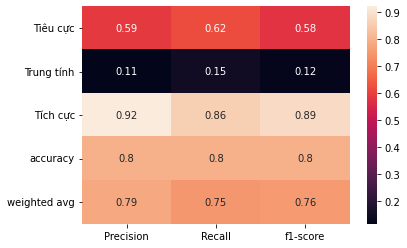

In [ ]:
sns.heatmap(pd.DataFrame(df).iloc[:-1, :], annot=True)

In [ ]:
result = df.T
print(result)

           Tiêu cực  Trung tính  Tích cực  Độ chính xác  macro avg  \
f1-score     0.5888      0.1149    0.9222        0.8013     0.5420   
Recall       0.6196      0.1526    0.8614        0.8013     0.5445   
Precision    0.5755      0.1218    0.8874        0.8013     0.5282   

           weighted avg  
f1-score          78.60  
Recall            75.08  
Precision         75.60  


# Overfitted!

In [ ]:
import random
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('always') 

epochs = 10
param_optimizer = list(BERT_Model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    BERT_Model.train() # mô hình khởi tạo cho việc huấn luyện
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    train_f1_0 = 0
    train_f1_1 = 0
    train_f1_2 = 0
    train_pre_0 = 0
    train_pre_1 = 0
    train_pre_2 = 0
    train_re_0 = 0
    train_re_1 = 0
    train_re_2 = 0
    #huấn luyện mô hình
    for step, batch in tqdm(enumerate(train_dataloader)): #load từng batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        BERT_Model.zero_grad() # xóa hết gradient của batch cũ tránh việc cộng dồn vào leaf.grad
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
        outputs = BERT_Model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        #logits có dạng 1 list chứa các tensor trong đó mỗi tensor có 3 điểm của từng nhãn thuộc về văn bản báo vì vậy cần np.argmax để xác định xem nhãn nào có điểm cao nhất
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1, tmp_train_f1_0, tmp_train_f1_1, tmp_train_f1_2, tmp_train_pre_0, tmp_train_pre_1, tmp_train_pre_2, tmp_train_re_0, tmp_train_re_1, tmp_train_re_2 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        train_f1_0 += tmp_train_f1_0
        train_f1_1 += tmp_train_f1_1
        train_f1_2 += tmp_train_f1_2
        train_pre_0 += tmp_train_pre_0
        train_pre_1 += tmp_train_pre_1
        train_pre_2 += tmp_train_pre_2
        train_re_0 += tmp_train_re_0
        train_re_1 += tmp_train_re_1
        train_re_2 += tmp_train_re_2
        nb_train_steps += 1
        
        loss.backward()  # Tính toán đạo hàm loss function theo lan truyền ngược
        torch.nn.utils.clip_grad_norm_(BERT_Model.parameters(), 1.0) # tránh việc bùng nổ gradient khi lan truyền ngược, giá trị tối đa của gradient là 1
        optimizer.step() #tối ưu gradient
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" precision score neg: {0:.4f}".format(train_pre_0/nb_train_steps))
    print(" precision score neu: {0:.4f}".format(train_pre_1/nb_train_steps))
    print(" precision score pos: {0:.4f}".format(train_pre_2/nb_train_steps))
    print(" recall score neg: {0:.4f}".format(train_re_0/nb_train_steps))
    print(" recall score neu: {0:.4f}".format(train_re_1/nb_train_steps))
    print(" recall score pos: {0:.4f}".format(train_re_2/nb_train_steps))
    print(" F1 score neg: {0:.4f}".format(train_f1_0/nb_train_steps))
    print(" F1 score neu: {0:.4f}".format(train_f1_1/nb_train_steps))
    print(" F1 score pos: {0:.4f}".format(train_f1_2/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))
    print("Running Validation...")
    #Sử dụng đánh giá mô hình
    BERT_Model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    eval_f1_0 = 0
    eval_f1_1 = 0
    eval_f1_2 = 0
    eval_pre_0 = 0
    eval_pre_1 = 0
    eval_pre_2 = 0
    eval_re_0 = 0
    eval_re_1 = 0
    eval_re_2 = 0
    for batch in tqdm(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad(): #không update tham số
            outputs = BERT_Model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1, tmp_eval_f1_0, tmp_eval_f1_1, tmp_eval_f1_2, tmp_eval_pre_0, tmp_eval_pre_1, tmp_eval_pre_2, tmp_eval_re_0, tmp_eval_re_1, tmp_eval_re_2 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            eval_f1_0 += tmp_eval_f1_0
            eval_f1_1 += tmp_eval_f1_1
            eval_f1_2 += tmp_eval_f1_2
            eval_pre_0 += tmp_eval_pre_0
            eval_pre_1 += tmp_eval_pre_1
            eval_pre_2 += tmp_eval_pre_2
            eval_re_0 += tmp_eval_re_0
            eval_re_1 += tmp_eval_re_1
            eval_re_2 += tmp_eval_re_2
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    print(" precision score neg: {0:.4f}".format(eval_pre_0/nb_eval_steps))
    print(" precision score neu: {0:.4f}".format(eval_pre_1/nb_eval_steps))
    print(" precision score pos: {0:.4f}".format(eval_pre_2/nb_eval_steps))
    print(" recall score neg: {0:.4f}".format(eval_re_0/nb_eval_steps))
    print(" recall score neu: {0:.4f}".format(eval_re_1/nb_eval_steps))
    print(" recall score pos: {0:.4f}".format(eval_re_2/nb_eval_steps))
    print(" F1 score neg: {0:.4f}".format(eval_f1_0/nb_eval_steps))
    print(" F1 score neu: {0:.4f}".format(eval_f1_1/nb_eval_steps))
    print(" F1 score pos: {0:.4f}".format(eval_f1_2/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


0it [00:00, ?it/s]

 Accuracy: 0.7832
 F1 score: 0.5141
 precision score neg: 0.5718
 precision score neu: 0.0101
 precision score pos: 0.9286
 recall score neg: 0.5169
 recall score neu: 0.0164
 recall score pos: 0.8382
 F1 score neg: 0.5085
 F1 score neu: 0.0116
 F1 score pos: 0.8755
 Average training loss: 0.5582
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.8013
 F1 score: 0.5431
 precision score neg: 0.5955
 precision score neu: 0.0298
 precision score pos: 0.9399
 recall score neg: 0.6016
 recall score neu: 0.0632
 recall score pos: 0.8428
 F1 score neg: 0.5694
 F1 score neu: 0.0393
 F1 score pos: 0.8853
======== Epoch 2 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8164
 F1 score: 0.5834
 precision score neg: 0.6990
 precision score neu: 0.0774
 precision score pos: 0.9298
 recall score neg: 0.6245
 recall score neu: 0.1132
 recall score pos: 0.8764
 F1 score neg: 0.6282
 F1 score neu: 0.0847
 F1 score pos: 0.8981
 Average training loss: 0.4679
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7980
 F1 score: 0.5438
 precision score neg: 0.5561
 precision score neu: 0.1228
 precision score pos: 0.9306
 recall score neg: 0.6121
 recall score neu: 0.1509
 recall score pos: 0.8590
 F1 score neg: 0.5506
 F1 score neu: 0.1236
 F1 score pos: 0.8895
======== Epoch 3 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8437
 F1 score: 0.6485
 precision score neg: 0.7464
 precision score neu: 0.2021
 precision score pos: 0.9358
 recall score neg: 0.6853
 recall score neu: 0.2649
 recall score pos: 0.9007
 F1 score neg: 0.6870
 F1 score neu: 0.2144
 F1 score pos: 0.9144
 Average training loss: 0.4156
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7967
 F1 score: 0.5513
 precision score neg: 0.5539
 precision score neu: 0.1737
 precision score pos: 0.9142
 recall score neg: 0.5911
 recall score neu: 0.2070
 recall score pos: 0.8744
 F1 score neg: 0.5492
 F1 score neu: 0.1702
 F1 score pos: 0.8903
======== Epoch 4 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8641
 F1 score: 0.6996
 precision score neg: 0.7693
 precision score neu: 0.3170
 precision score pos: 0.9396
 recall score neg: 0.7273
 recall score neu: 0.3877
 recall score pos: 0.9180
 F1 score neg: 0.7239
 F1 score neu: 0.3267
 F1 score pos: 0.9253
 Average training loss: 0.3738
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7882
 F1 score: 0.5494
 precision score neg: 0.5072
 precision score neu: 0.1860
 precision score pos: 0.9194
 recall score neg: 0.5937
 recall score neu: 0.2202
 recall score pos: 0.8632
 F1 score neg: 0.5215
 F1 score neu: 0.1837
 F1 score pos: 0.8863
======== Epoch 5 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8863
 F1 score: 0.7493
 precision score neg: 0.8035
 precision score neu: 0.4006
 precision score pos: 0.9498
 recall score neg: 0.7710
 recall score neu: 0.4599
 recall score pos: 0.9330
 F1 score neg: 0.7654
 F1 score neu: 0.4038
 F1 score pos: 0.9387
 Average training loss: 0.3294
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7724
 F1 score: 0.5164
 precision score neg: 0.4114
 precision score neu: 0.1965
 precision score pos: 0.9216
 recall score neg: 0.5691
 recall score neu: 0.1842
 recall score pos: 0.8491
 F1 score neg: 0.4526
 F1 score neu: 0.1753
 F1 score pos: 0.8800
======== Epoch 6 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.8996
 F1 score: 0.7773
 precision score neg: 0.8145
 precision score neu: 0.4489
 precision score pos: 0.9560
 recall score neg: 0.7911
 recall score neu: 0.4980
 recall score pos: 0.9395
 F1 score neg: 0.7830
 F1 score neu: 0.4493
 F1 score pos: 0.9456
 Average training loss: 0.3012
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7750
 F1 score: 0.5246
 precision score neg: 0.4498
 precision score neu: 0.1860
 precision score pos: 0.9155
 recall score neg: 0.6046
 recall score neu: 0.1851
 recall score pos: 0.8601
 F1 score neg: 0.4894
 F1 score neu: 0.1680
 F1 score pos: 0.8827
======== Epoch 7 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9166
 F1 score: 0.8185
 precision score neg: 0.8327
 precision score neu: 0.5282
 precision score pos: 0.9631
 recall score neg: 0.8143
 recall score neu: 0.5789
 recall score pos: 0.9495
 F1 score neg: 0.8078
 F1 score neu: 0.5296
 F1 score pos: 0.9543
 Average training loss: 0.2597
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7717
 F1 score: 0.5180
 precision score neg: 0.5165
 precision score neu: 0.1254
 precision score pos: 0.9025
 recall score neg: 0.5893
 recall score neu: 0.1553
 recall score pos: 0.8543
 F1 score neg: 0.5216
 F1 score neu: 0.1252
 F1 score pos: 0.8736
======== Epoch 8 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9276
 F1 score: 0.8449
 precision score neg: 0.8486
 precision score neu: 0.5603
 precision score pos: 0.9687
 recall score neg: 0.8407
 recall score neu: 0.6095
 recall score pos: 0.9545
 F1 score neg: 0.8283
 F1 score neu: 0.5623
 F1 score pos: 0.9598
 Average training loss: 0.2444
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7724
 F1 score: 0.5276
 precision score neg: 0.5698
 precision score neu: 0.1254
 precision score pos: 0.8911
 recall score neg: 0.5895
 recall score neu: 0.1658
 recall score pos: 0.8705
 F1 score neg: 0.5431
 F1 score neu: 0.1286
 F1 score pos: 0.8756
======== Epoch 9 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9362
 F1 score: 0.8624
 precision score neg: 0.8548
 precision score neu: 0.5984
 precision score pos: 0.9738
 recall score neg: 0.8560
 recall score neu: 0.6396
 recall score pos: 0.9588
 F1 score neg: 0.8422
 F1 score neu: 0.5973
 F1 score pos: 0.9647
 Average training loss: 0.2223
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7605
 F1 score: 0.5316
 precision score neg: 0.5746
 precision score neu: 0.1635
 precision score pos: 0.8662
 recall score neg: 0.5726
 recall score neu: 0.1702
 recall score pos: 0.8788
 F1 score neg: 0.5400
 F1 score neu: 0.1531
 F1 score pos: 0.8679
======== Epoch 10 / 10 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9444
 F1 score: 0.8772
 precision score neg: 0.8645
 precision score neu: 0.6197
 precision score pos: 0.9769
 recall score neg: 0.8677
 recall score neu: 0.6592
 recall score pos: 0.9625
 F1 score neg: 0.8542
 F1 score neu: 0.6218
 F1 score pos: 0.9684
 Average training loss: 0.1953
Running Validation...


  0%|          | 0/95 [00:00<?, ?it/s]

 Accuracy: 0.7599
 F1 score: 0.5281
 precision score neg: 0.5341
 precision score neu: 0.1851
 precision score pos: 0.8732
 recall score neg: 0.5902
 recall score neu: 0.1642
 recall score pos: 0.8775
 F1 score neg: 0.5274
 F1 score neu: 0.1605
 F1 score pos: 0.8704
Training complete!
